In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from pprint import pprint

Дано уравнение 
$$
\frac {\partial^2 u}{\partial t^2} = \frac{E}{\rho}\frac {\partial^2 u}{\partial x^2}
$$

$$
u(0, x) = p(x),\ \frac {\partial u(0, x)}{\partial t} = q(x),\ u(t, 0) = 0,\ u(t, L) = 0
$$
Аппроксимируем вторую производную следующей схемой
$$
\frac {\partial^2 u}{\partial x^2} = \frac {u(x+h) - 2\cdot u(x) + u(x-h)}{h^2}
$$

$
u_{j}^0 = p_{j} 
$

$
u_{j}^1 = u_{j}^0 + \tau \cdot \frac {\partial u_{j}^0}{\partial t} + \frac {\tau^2}{2} \frac {\partial u_{j}^0}{\partial t^2} = p_{j} + \tau \cdot q_{j} + \frac {\tau^2 E}{2\cdot \rho} \frac {\partial^2 u_j}{\partial x^2} = p_{j} + \tau \cdot q_{j} + \frac {\tau^2 E}{2\cdot h_x^2 \rho} (p_{j+1} - 2\cdot p_j + p_{j-1})
$

$
\frac {(u_{j}^{i+1} - 2\cdot u_j^i + u_{j}^{i-1})}{\tau^2} = \frac{E}{\rho} \frac {(u_{j+1}^i - 2\cdot u_j^i + u_{j-1}^i)}{h_x^2}
$, отсюда получаем:

$
u_{j}^{i+1} = \frac{\tau^2 E}{\rho h_x^2} {(u_{j+1}^i - 2\cdot u_j^i + u_{j-1}^i)} + 2\cdot u_j^i - u_{j}^{i-1}
$

Порядок точности второй и по $h_x$, и по  $\tau$. 

In [105]:
# C = E / ro
def solve(p, q, C, L, N_X, tau, T = None):
    x = np.linspace(0, L, N_X)
    h_x = x[1] - x[0]
    n = 0
    solution_prev_prev = np.zeros(N_X)
    solution_prev_prev[1:-1] = p(x[1:-1])
    yield solution_prev_prev
    n += 1
    solution_prev = np.zeros(N_X)
    solution_prev[1:-1] = tau * q(x) + p(x[1:-1]) + tau ** 2 * C / (2 * h_x ** 2) * \
                          (p(x[2:]) - 2 * p(x[1:-1]) + p(x[:-2]))
    yield solution_prev
    n += 1
    while T is None or n*tau <= T:
        solution = np.zeros(N_X)
        solution[1:-1] = C * ((tau / h_x) ** 2) * (solution_prev[2:] - 2*solution_prev[1:-1] + solution_prev[:-2]) + \
                         2*solution_prev[1:-1] - solution_prev_prev[1:-1]
        yield solution
        n += 1
        solution_prev_prev = solution_prev
        solution_prev = solution
        

In [106]:
L = 18
p = lambda x: 0.2*np.sin(2*np.pi * x / L)
q = lambda x: 0
ro = 5.9e5
E = 120e9

x = np.linspace(0, L, 100)
y = list(solve(p, q, E / ro, L, 100, 1e-4, 1e-1))

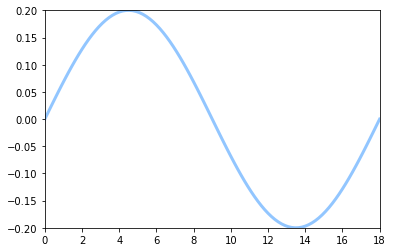

In [109]:
plt.style.use('seaborn-pastel')
fig = plt.figure()
ax = plt.axes(xlim=(0, 18), ylim=(-0.2, 0.2))
line, = ax.plot([], [], lw=3)

def init():
    line.set_data([], [])
    return line,

def animate(i):
    line.set_data(x, y[i % len(y)])
    return line,
 
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=400, interval=20, blit=True)
  
anim.save('sine_wave.mp4', writer='ffmpeg')

$$
\frac {\partial^2 u}{\partial t^2} - \frac {\partial^2 u}{\partial x^2} = f(x, t), 0 \lg t \le T
$$
$$
u(0, t) = 0,\ u(1, t) = 0,\ 0 < t \le T
$$
$$
u(x, 0) = p(x),\ u'_t(x, 0) = q(x),\ 0 < t \le T
$$


$$
\frac {u^{i+1}_j - 2\cdot u^i_j + u^{i-1}_j}{\tau ^2} - \frac{u^{i}_{j+1} - 2\cdot u^i_j + u^{i}_{j-1}}{h ^2} = f^i_j
$$


$
u^{0}_{j} = p_j
$

$
u^{1}_{j} = p_j + \tau \cdot q_j + \frac {\tau ^ 2}{2}(f^0_j - \frac{p_{k+1} - 2\cdot p_k + p_{k-1}}{h^2})  
$

$
u^{i}_{0} = 0
$

$
u^{i}_{N} = 0
$


In [102]:
a = 2
b = 1
# shift left-down corner in (0,0)
p = lambda x, y: np.arctan(np.cos(np.pi*(x/a - 0.5))) * np.ones(shape=y.shape) 
q = lambda x, y: np.sin(2*np.pi*(x/a - 0.5))*np.sin(2*np.pi*(y/b - 0.5))

In [103]:
def solve2(N_X, N_Y, tau, T = None):
    # fill t = 0
    n = 0
    solution_prev_prev = np.zeros((N_X, N_Y))
    x = np.array([np.linspace(0, a, N_X)]).T
    y = np.array([np.linspace(0, b, N_Y)])
#     print(x)
    h_x = x[1, 0] - x[0, 0]
    h_y = y[0, 1] - y[0, 0]
#     print(h_x, h_y)
    solution_prev_prev[1:-1, :] = p(x[1:-1], y)
    yield solution_prev_prev
    # fill t = tau
    n += 1
    solution_prev = np.zeros((N_X, N_Y))
#     solution_prev[1:-1, 1:-1] = tau * q(x[1:-1], y[:, 1:-1]) + \
#                                 (tau ** 2) / (2 * h_x ** 2) * p(x[2:], y[:, 1:-1]) + \
#                                 (tau ** 2) / (2 * h_x ** 2) * p(x[:-2], y[:, 1:-1]) + \
#                                 (tau ** 2) / (2 * h_y ** 2) * p(x[1:-1], y[:, 2:]) + \
#                                 (tau ** 2) / (2 * h_y ** 2) * p(x[1:-1], y[:, :-2]) + \
#                                 (1 - (tau / (h_x * h_y)) ** 2 * (h_x ** 2 + h_y ** 2)) * p(x[1:-1], y[:, 1:-1])
    solution_prev[1:-1, 1:-1] = tau * q(x[1:-1], y[:, 1:-1]) + \
                                (tau ** 2) / (2 * h_x ** 2) * (p(x[2:], y[:, 1:-1]) - 2*p(x[1:-1], y[:, 1:-1]) + p(x[:-2], y[:, 1:-1])) + \
                                (tau ** 2) / (2 * h_y ** 2) * (p(x[1:-1], y[:, 2:]) - 2*p(x[1:-1], y[:, 1:-1]) + p(x[1:-1], y[:, :-2])) + \
                                p(x[1:-1], y[:, 1:-1])
    solution_prev[1:-1, 0] = solution_prev[1:-1, 1]
    solution_prev[1:-1, -1] = solution_prev[1:-1, -2]
    yield solution_prev
    n += 1
    while T is None or n*tau <= T:
        solution = np.zeros((N_X, N_Y))
#         solution[1:-1, 1:-1] = (tau / h_x) ** 2 * (solution_prev[2:, 1:-1] + solution_prev[:-2, 1:-1]) + \
#                                (tau / h_y) ** 2 * (solution_prev[1:-1, 2:] + solution_prev[1:-1, :-2]) + \
#                                2*(1 - (tau / (h_x * h_y)) ** 2 * (h_x ** 2 + h_y ** 2)) * solution_prev[1:-1, 1:-1] - \
#                                solution_prev_prev[1:-1, 1:-1]
        solution[1:-1, 1:-1] = (tau / h_x) ** 2 * (solution_prev[2:, 1:-1] - 2*solution_prev[1:-1, 1:-1] + solution_prev[:-2, 1:-1]) + \
                               (tau / h_y) ** 2 * (solution_prev[1:-1, 2:] - 2*solution_prev[1:-1, 1:-1] + solution_prev[1:-1, :-2]) + \
                               2*solution_prev[1:-1, 1:-1] - \
                               solution_prev_prev[1:-1, 1:-1]
        solution[1:-1, 0] = solution[1:-1, 1]
        solution[1:-1, -1] = solution[1:-1, -2]
        yield solution
        n += 1
        solution_prev_prev = solution_prev
        solution_prev = solution


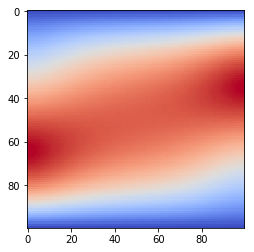

In [104]:

fig = plt.figure()


# def f(x, y):
#     return np.sin(x) + np.cos(y)


n_x = 100
n_y = 100

x = np.linspace(0, a, n_x)
y = np.linspace(0, b, n_y).reshape(-1, 1)
# print(x, y)
# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []
count  = 0
for i in solve2(n_x, n_y, 0.001, 4):
#     print(i[1])
#     count += 1
    ims.append([plt.imshow(i, animated=True, cmap=plt.cm.coolwarm)])

ani = animation.ArtistAnimation(fig, ims, interval=20, blit=True,
                                repeat_delay=100)

# To save the animation, use e.g.
#
# ani.save("movie.mp4")
#
# or
#
# from matplotlib.animation import FFMpegWriter
# writer = FFMpegWriter(fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save("movie.mp4", writer=writer)

ani.save("movie.mp4")
plt.show()


In [85]:
for i in solve2(100, 100, 0.001, 1):
    print(i[1])

[0.03171729 0.03171729 0.03171729 0.03171729 0.03171729 0.03171729
 0.03171729 0.03171729 0.03171729 0.03171729 0.03171729 0.03171729
 0.03171729 0.03171729 0.03171729 0.03171729 0.03171729 0.03171729
 0.03171729 0.03171729 0.03171729 0.03171729 0.03171729 0.03171729
 0.03171729 0.03171729 0.03171729 0.03171729 0.03171729 0.03171729
 0.03171729 0.03171729 0.03171729 0.03171729 0.03171729 0.03171729
 0.03171729 0.03171729 0.03171729 0.03171729 0.03171729 0.03171729
 0.03171729 0.03171729 0.03171729 0.03171729 0.03171729 0.03171729
 0.03171729 0.03171729 0.03171729 0.03171729 0.03171729 0.03171729
 0.03171729 0.03171729 0.03171729 0.03171729 0.03171729 0.03171729
 0.03171729 0.03171729 0.03171729 0.03171729 0.03171729 0.03171729
 0.03171729 0.03171729 0.03171729 0.03171729 0.03171729 0.03171729
 0.03171729 0.03171729 0.03171729 0.03171729 0.03171729 0.03171729
 0.03171729 0.03171729 0.03171729 0.03171729 0.03171729 0.03171729
 0.03171729 0.03171729 0.03171729 0.03171729 0.03171729 0.0317

[0.03358343 0.03358343 0.0336042  0.03364535 0.0337071  0.03378952
 0.03389063 0.03401384 0.03415418 0.03431309 0.03449454 0.03469055
 0.03489938 0.03513083 0.03538717 0.03565604 0.03592017 0.03616659
 0.03638823 0.03658187 0.03674599 0.03687975 0.03698256 0.037054
 0.03709378 0.03710174 0.03707786 0.03702222 0.03693505 0.0368167
 0.03666765 0.0364885  0.03627997 0.0360429  0.03577824 0.03548706
 0.03517053 0.03482993 0.03446662 0.03408208 0.03367785 0.03325555
 0.03281689 0.03236363 0.03189761 0.03142068 0.03093479 0.03044187
 0.02994393 0.02944295 0.02894097 0.02843999 0.02794205 0.02744913
 0.02696324 0.02648631 0.02602029 0.02556703 0.02512837 0.02470607
 0.02430184 0.0239173  0.02355399 0.02321339 0.02289686 0.02260568
 0.02234102 0.02210395 0.02189542 0.02171627 0.02156722 0.02144887
 0.0213617  0.02130606 0.02128218 0.02129014 0.02132992 0.02140136
 0.02150417 0.02163793 0.02180205 0.02199569 0.02221733 0.02246375
 0.02272788 0.02299675 0.02325309 0.02348454 0.02369337 0.0238893

[0.0351454  0.0351454  0.03512412 0.03508174 0.03501837 0.03493434
 0.03483024 0.03470604 0.0345634  0.0344014  0.03422285 0.03402675
 0.03381499 0.03358944 0.03334858 0.03309693 0.03283403 0.03255954
 0.03227909 0.03199137 0.03169554 0.03139837 0.03110059 0.03079819
 0.03049571 0.03020077 0.02991173 0.02962284 0.02933652 0.02906322
 0.02881094 0.02857811 0.02835519 0.02813049 0.02789467 0.02764217
 0.02737054 0.02707931 0.02676902 0.0264407  0.02609559 0.02573508
 0.02536059 0.02497365 0.0245758  0.02416865 0.02375384 0.02333304
 0.02290795 0.02248026 0.02205172 0.02162404 0.02119894 0.02077814
 0.02036333 0.01995618 0.01955834 0.01917139 0.01879691 0.01843639
 0.01809129 0.01776297 0.01745268 0.01716144 0.01688982 0.01663731
 0.01640149 0.01617679 0.01595387 0.01572105 0.01546877 0.01519546
 0.01490914 0.01462026 0.01433122 0.01403628 0.0137338  0.01343139
 0.01313362 0.01283644 0.01254062 0.0122529  0.01197245 0.01169796
 0.01143506 0.0111834  0.01094255 0.01071699 0.01050524 0.0103

[0.02602686 0.02602686 0.02599804 0.02594061 0.02585468 0.02574084
 0.02559939 0.02543114 0.02523683 0.02501714 0.02477357 0.02450638
 0.02421799 0.02390832 0.02358013 0.02323405 0.02287172 0.02249584
 0.02210626 0.02170694 0.02129839 0.02088227 0.02046259 0.02003865
 0.01961402 0.01919182 0.01877105 0.01835627 0.01795031 0.01755168
 0.01716494 0.01679396 0.01643655 0.01609538 0.01577654 0.0154792
 0.01520146 0.01494886 0.01472654 0.01453181 0.01436193 0.01422186
 0.01411868 0.01405226 0.01401644 0.0140077  0.01402967 0.01408873
 0.01418587 0.01431195 0.01444883 0.01457491 0.01467205 0.01473111
 0.01475308 0.01474434 0.01470852 0.0146421  0.01453892 0.01439885
 0.01422897 0.01403424 0.01381192 0.01355932 0.01328158 0.01298424
 0.0126654  0.01232423 0.01196682 0.01159584 0.0112091  0.01081047
 0.01040451 0.00998973 0.00956895 0.00914676 0.00872213 0.00829818
 0.00787851 0.00746239 0.00705384 0.00665452 0.00626494 0.00588905
 0.00552673 0.00518064 0.00485245 0.00454279 0.0042544  0.00398

[0.0064224  0.0064224  0.00643319 0.0064548  0.00648701 0.00652997
 0.00658322 0.00664699 0.00672065 0.00680442 0.00689765 0.00700034
 0.00711208 0.00723238 0.00736137 0.00749784 0.00764248 0.00779367
 0.00795205 0.00811649 0.00828654 0.00846249 0.00864239 0.00882741
 0.00901564 0.00920669 0.00940053 0.00959375 0.00978592 0.00997244
 0.01014663 0.01030299 0.01043011 0.01051905 0.01056567 0.01056666
 0.01052863 0.01046289 0.01037393 0.01026375 0.01013084 0.00996908
 0.00978145 0.00957966 0.00936701 0.00913904 0.00889682 0.00864639
 0.0083911  0.008132   0.00787133 0.00761224 0.00735694 0.00710651
 0.00686429 0.00663632 0.00642367 0.00622188 0.00603425 0.00587249
 0.00573958 0.0056294  0.00554044 0.0054747  0.00543667 0.00543766
 0.00548428 0.00557322 0.00570034 0.0058567  0.00603089 0.00621741
 0.00640958 0.0066028  0.00679664 0.00698769 0.00717592 0.00736094
 0.00754084 0.00771679 0.00788684 0.00805128 0.00820966 0.00836085
 0.00850549 0.00864196 0.00877095 0.00889125 0.00900299 0.0091

[-7.98523682e-03 -7.98523682e-03 -7.94781046e-03 -7.87313935e-03
 -7.76147045e-03 -7.61335841e-03 -7.42938568e-03 -7.21057127e-03
 -6.95816026e-03 -6.67404503e-03 -6.36103328e-03 -6.02296698e-03
 -5.66580665e-03 -5.29665874e-03 -4.92528095e-03 -4.56070395e-03
 -4.21213908e-03 -3.88357085e-03 -3.57509459e-03 -3.28076179e-03
 -2.99305390e-03 -2.70740282e-03 -2.42368897e-03 -2.14851216e-03
 -1.88565869e-03 -1.63568358e-03 -1.39276982e-03 -1.15182282e-03
 -9.15265610e-04 -6.86524443e-04 -4.68541982e-04 -2.56508416e-04
 -4.57502941e-05  1.60192283e-04  3.59054226e-04  5.51006638e-04
  7.40271899e-04  9.28686409e-04  1.11033537e-03  1.28654611e-03
  1.46261936e-03  1.63599533e-03  1.80505010e-03  1.97183294e-03
  2.13743734e-03  2.30195966e-03  2.46388173e-03  2.62419876e-03
  2.78570146e-03  2.94614348e-03  3.10465407e-03  3.26509609e-03
  3.42659879e-03  3.58691581e-03  3.74883789e-03  3.91336021e-03
  4.07896461e-03  4.24574744e-03  4.41480222e-03  4.58817819e-03
  4.76425143e-03  4.94046